# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [4]:
!git clone -b develop https://github.com/korotkovaliza/cvr_course

fatal: destination path 'cvr_course' already exists and is not an empty directory.


In [5]:
cd cvr_course/notebooks

/content/cvr_course/notebooks


In [202]:
import numpy as np
import cv2
import time
import os
import math
import sys
import glob
import shapely.geometry as geom
from matplotlib import pyplot as plt

In [203]:
def to_RGB(img):
  return cv2.cvtColor (img, cv2.COLOR_BGR2RGB)

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m49s487.png


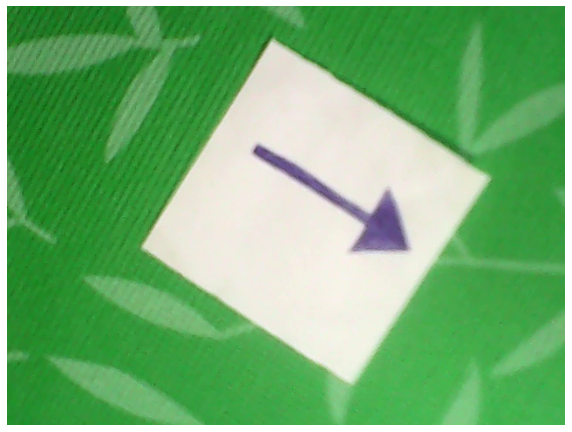

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m29s941.png


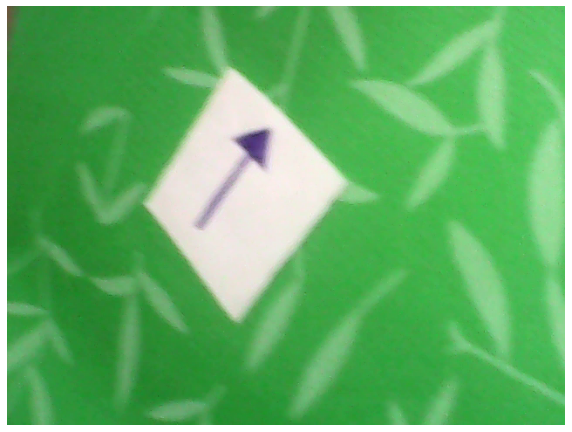

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m41s874.png


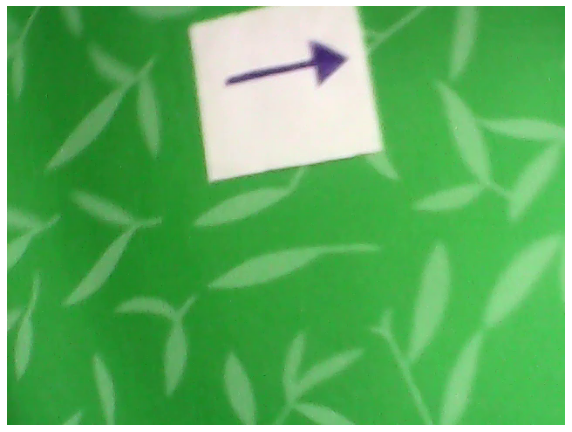

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m33s362.png


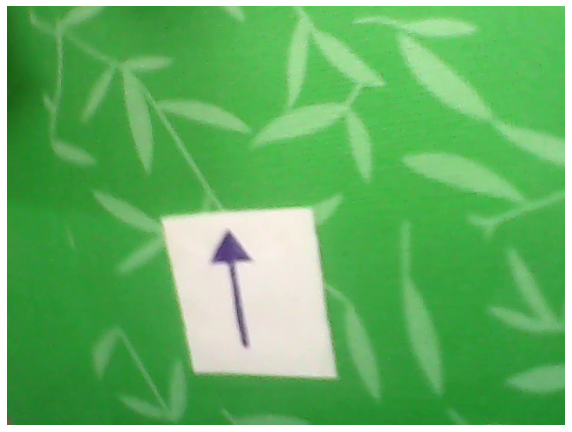

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m44s163.png


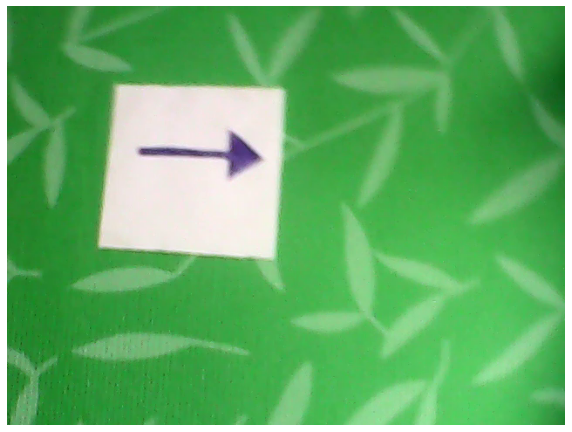

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m46s644.png


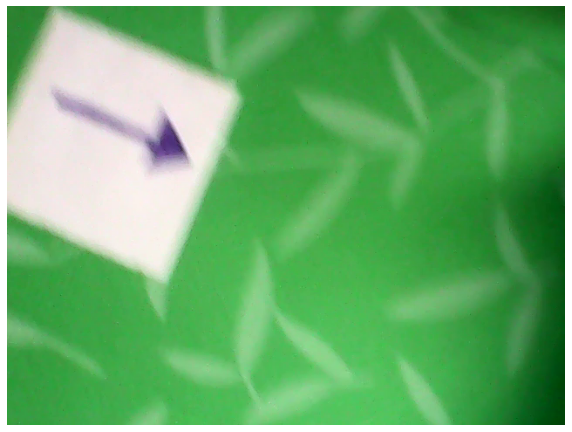

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m22s212.png


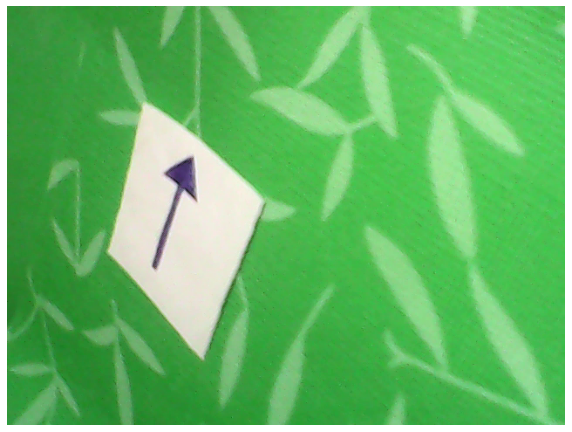

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m27s294.png


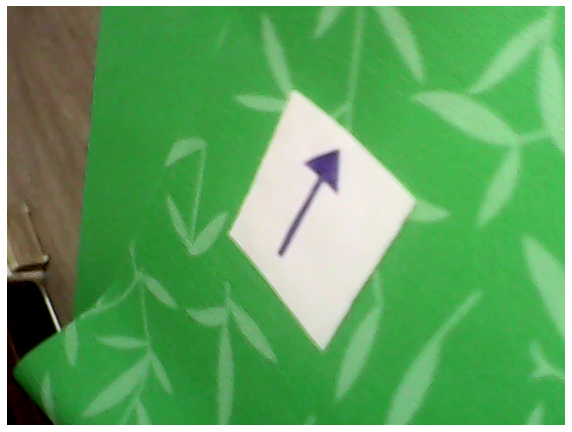

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m51s638.png


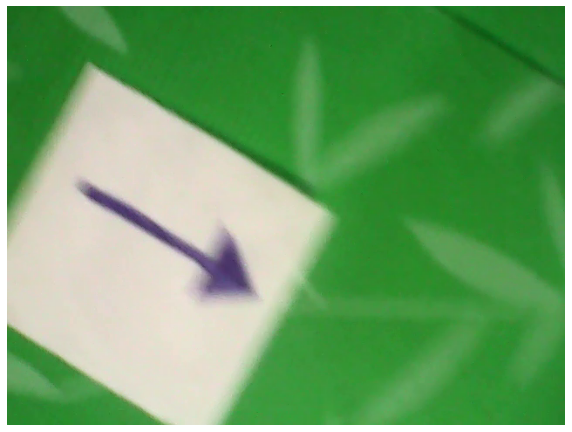

../data/imgs/arrow/vlcsnap-2020-10-21-18h01m36s056.png


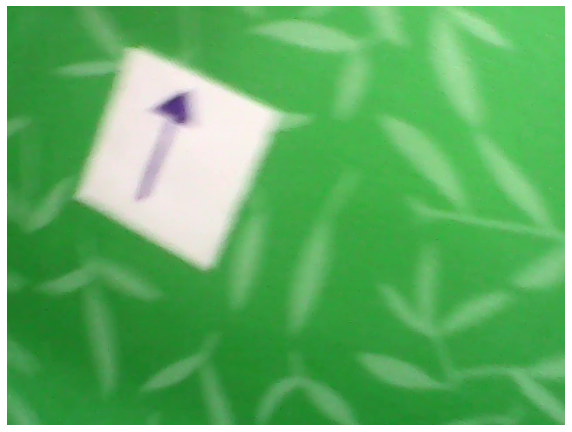

In [204]:
images_data = glob.glob('../data/imgs/arrow/*.png')
images = []
for fname in images_data:
    print(fname)
    img = cv2.imread(fname, cv2.IMREAD_COLOR)
    images.append(img)
    plt.imshow(to_RGB(img))
    plt.axis('off')
    plt.show()

In [205]:
def find_contour (img, low_th=(200, 200, 200), high_th=(255, 255, 255)):
    mask = cv2.inRange (img, low_th, high_th)
    contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = None
    max_len = -1
    for contour in contours:
      len = cv2.arcLength(contour, True)
      if len > max_len:
        max_len = len
        cnt = contour

    approx = cv2.convexHull (cnt)
    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)
    return approx

In [206]:
def find_distance (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)
    contour = find_contour (img, low_th, high_th)
    length = cv2.arcLength (contour, True)
    distance = 180.0 * 364 / length
    return distance

In [207]:
for i in range(len(images)):
  print(i+1, ") ",  find_distance(images[i]), sep="")

1) 58.213898179172
2) 91.4181030090751
3) 92.1951292094964
4) 95.15204916054759
5) 86.98571825076148
6) 77.07543760345204
7) 96.64850710230294
8) 91.934760625742
9) 66.25763790351805
10) 94.81533612993083


In [208]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
  
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[({0, 1, 2, 3} - {np.argmin(s), np.argmax(s), np.argmin(diff)}).pop()]
    return rect



In [209]:
def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

In [210]:
def view_from_above(img):
  return four_point_transform(img, np.asarray(find_contour(img))[:, 0, :])

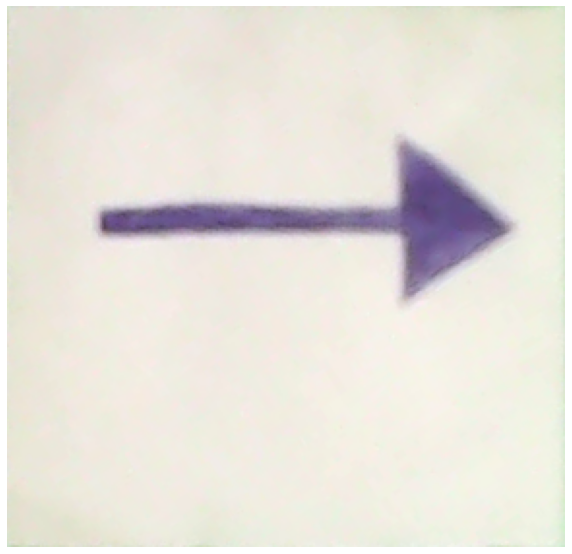

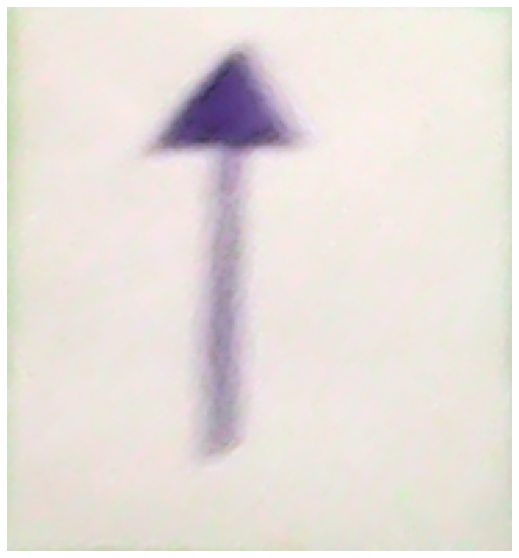

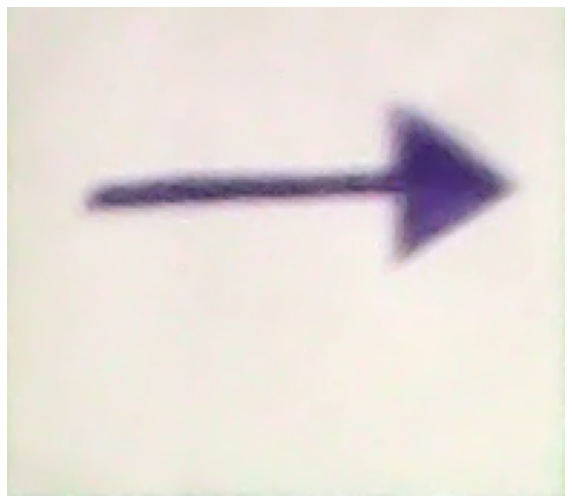

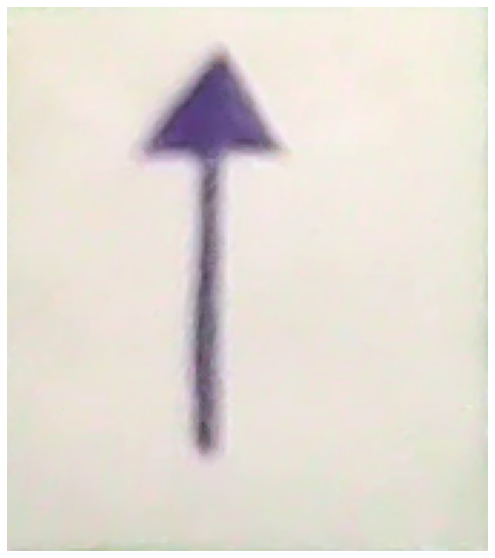

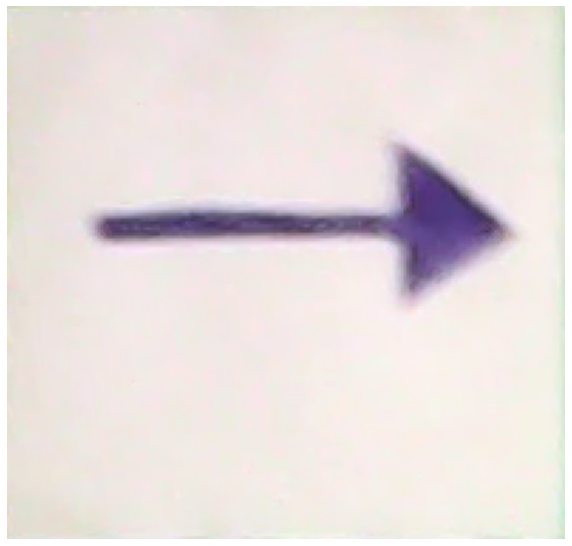

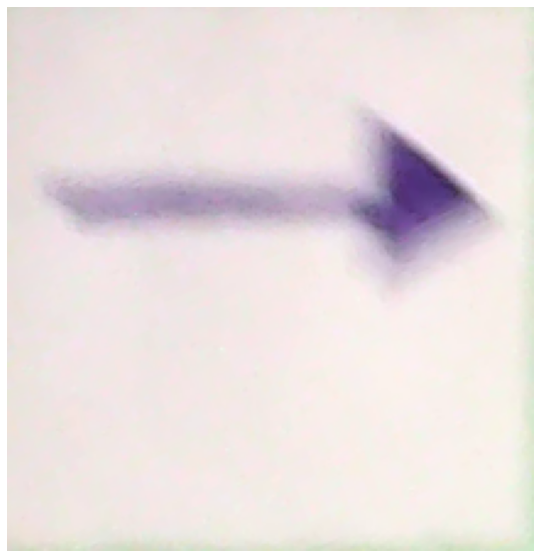

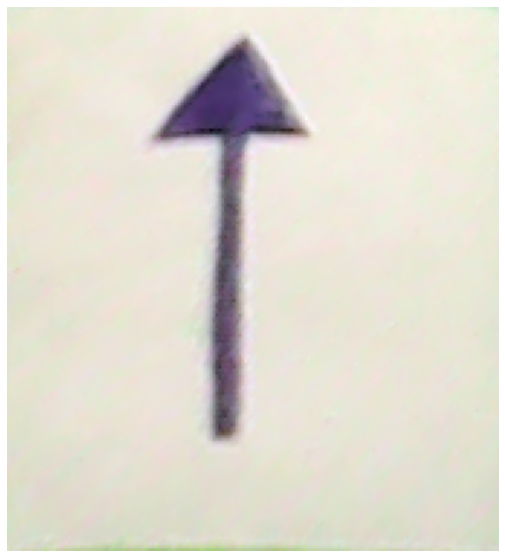

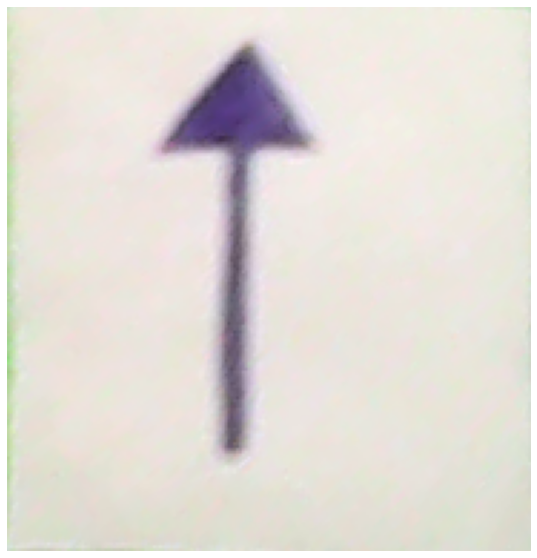

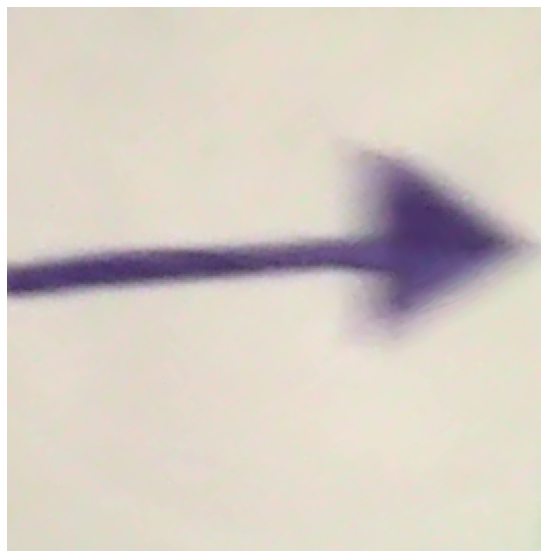

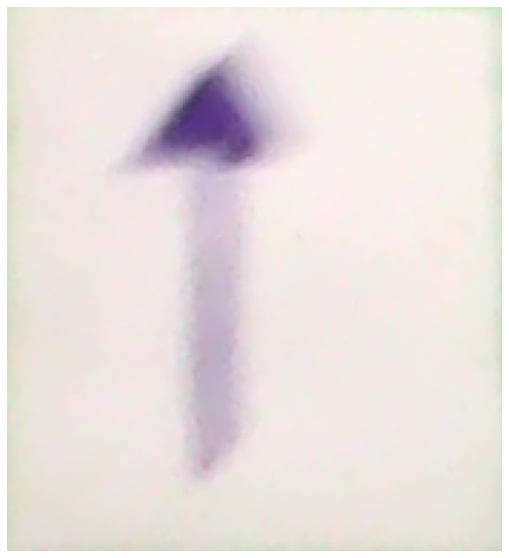

In [211]:
for i in range(len(images)):
    plt.rcParams["figure.figsize"] = (10,10)
    plt.imshow(to_RGB(view_from_above(images[i])))
    plt.axis('off')
    plt.show()

Найдем направление с помощью следующего способа: сначала ищем направление в "виде сверху"(два варианта - вправо и вверх), если получаем вправо, то направление стрелки совпадает с направлением горизонтальной стороны листочка, на котором стрелочка(вектор с началом в 3 вершине листочка, а с концом в 2 вершине листочка), если получаем вверх, то направление стрелки совпадает с направлением вертикальной стороны листочка, на котором стрелочка(вектор с началом в 3 вершине листочка, а с концом в 4 вершине листочка) Для направлений влево и вниз аналогично. 

In [212]:
from random import randrange
from math import pi, fabs, sin, cos
from numpy.linalg import inv

In [213]:
def p (img):
    low_th  = (200, 200, 200)
    high_th = (255, 255, 255)
    return(find_contour(img, low_th, high_th))

In [214]:
def skeletonize(arrow, lower_thr):
    gray_arrow = cv2.cvtColor(arrow, cv2.COLOR_BGR2GRAY)
    size = np.size(gray_arrow)
    skel = np.zeros(gray_arrow.shape,np.uint8)
    ret,im = cv2.threshold(gray_arrow,lower_thr,255,0)

    USE_OPENCV_CONTRIB = 0 

# Doing skeletonisation
    if USE_OPENCV_CONTRIB:
    # Doing Zhang-Suen skeletonisation (gives better results, but requires opencv-contrib-python package installed)
        skel = cv2.ximgproc.thinning(im)
    else:
    # Doing morphological skeletonisation with barebone OpenCV
        element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
        done = False
        while( not done):
            eroded = cv2.erode(im,element)
            temp = cv2.dilate(eroded,element)
            temp = cv2.subtract(im,temp)
            skel = cv2.bitwise_or(skel,temp)
            im = eroded.copy()

            zeros = size - cv2.countNonZero(im)
            if zeros==size:
                done = True

    return skel

In [215]:
def make_array_for_direction_line(arrow, threshold):
    x_train = []
    y_train = []
    cols_num = arrow.shape[1]
    rows_num = arrow.shape[0]
    for i in range(int(0.1*rows_num), int(0.9*rows_num)):
        for j in range(int(0.1*cols_num), int(0.9*cols_num)):
            if arrow[i][j] > threshold:
                x_train.append(j)
                y_train.append(i)
    return np.array(x_train).reshape(-1, 1), np.array(y_train)

In [216]:
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN

In [217]:
def intersection_point(a1, b1, a2, b2):
    x_common = (b2 - b1) / (a1 - a2)
    y_common = a1 * x_common + b1
    return x_common, y_common

In [218]:
from numpy.lib.function_base import kaiser
def get_direction_on_top_arrow(top_arrow, skel_thr, eps, k):
    skel_arrow = skeletonize(top_arrow, skel_thr)

    x_train, y_train = make_array_for_direction_line(skel_arrow, skel_thr)
    points = np.column_stack([x_train, y_train])

    clustering = DBSCAN(eps=eps, min_samples=10).fit(points)
    x_side_1 = []
    x_side_2 = []
    y_side_1 = []
    y_side_2 = []

    for i in range(clustering.labels_.shape[0]):
        if clustering.labels_[i] == 0:
            x_side_1.append(x_train[i])
            y_side_1.append(y_train[i])
        elif clustering.labels_[i] == 1:
            x_side_2.append(x_train[i])
            y_side_2.append(y_train[i])     
    x_side_1 = np.array(x_side_1)
    y_side_1 = np.array(y_side_1)
    x_side_2 = np.array(x_side_2)
    y_side_2 = np.array(y_side_2)

    model_1 = LinearRegression().fit(x_side_1, y_side_1)
    model_2 = LinearRegression().fit(x_side_2, y_side_2)
    y_pred_1 = model_1.predict(x_side_1)
    y_pred_2 = model_2.predict(x_side_2)

    x_end, y_end = intersection_point(model_1.coef_[0], model_1.intercept_, model_2.coef_[0], model_2.intercept_)
    x_start = (np.mean(x_side_1) + np.mean(x_side_2)) / 2
    y_start = (np.mean(y_side_1) + np.mean(y_side_2)) / 2
    
    #print(x_start, y_start, x_end, y_end)
    if np.abs(x_end - x_start) > np.abs(y_end - y_start):
        if x_end > x_start:
            print("Right")
            print("вектор направления с началом в", p(images[k])[2][0], "и с концом в", p(images[4])[1][0])
        else:
            print("Left")
            print("вектор направления с началом в", p(images[k])[1][0], "и с концом в", p(images[4])[2][0])
    else:
        if y_end > y_start:
            print("Down")
            print("вектор направления с началом в", p(images[k])[3][0], "и с концом в", p(images[4])[2][0])
        else:
            print("Up")
            print("вектор направления с началом в", p(images[k])[2][0], "и с концом в", p(images[4])[3][0])

 

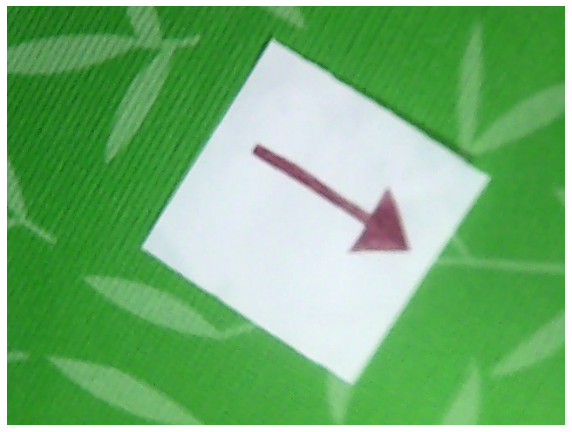

Right
вектор направления с началом в [108 273] и с концом в [305 287]


In [219]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(images[0])
plt.axis('off')
plt.show()
get_direction_on_top_arrow(view_from_above(images[4]), 200, 8, 4)